In [1]:
import pickle as pkl
import numpy as np
import time
import matplotlib.pyplot as plt
import os, sys
curdir=os.getcwd()
os.environ['GC_DM_BASE']=os.path.dirname(curdir)
os.environ['GC_DM_DATA']='/data/user/tchau/DarkMatter_OscNext/'

sys.path.append("../Utils/")
sys.path.append("../Spectra/")
sys.path.append("../PDFs/")
sys.path.append("../DetResponse/")
from Detector import *

In [4]:
def GetData(cut='default', v='2.04'):
    input_files = []
    dat_dir = f"/data/user/tchau/DarkMatter_OscNext/Sample/Data/"
    # Take all burnsample:
    print(f'Loading {dat_dir}')
    for year in range(12, 22):
        infile = dat_dir + "data_IC86.{}_level7_v0{}_pass2.pkl".format(year, v)
        print(f'loading {infile}')
        dat = pkl.load(open(infile, 'rb'))
        input_files = np.append(input_files, dat)

    array_recopsi = np.array([])
    array_recoE = np.array([])
    array_evttime = np.array([])
    array_recoRA = np.array([])

    # input_file = data['burnsample']
    for input_file in input_files:
        # define cut:
        if cut=='default':
            loc = np.where((input_file["L7muon_classifier_up"]>0.4) &
                            (input_file["L4noise_classifier"]>0.95) &
                            (input_file["L7reco_vertex_z"]>-500.) &
                            (input_file["L7reco_vertex_z"]<-200.) &
                            (input_file["L7reco_vertex_rho36"]<300.) &
                            (input_file["L5nHit_DOMs"]>2.5) &
                            (input_file["L7_ntop15"]<2.5) &
                            (input_file["L7_nouter"]<7.5) &
                            (input_file["L7reco_time"]<14500.))
        elif cut=='OscNext':
            loc = np.where((input_file["L7muon_classifier_up"]>0.4) &
                (input_file["L4noise_classifier"]>0.95) &
                (input_file["L7reco_vertex_z"]>-500.) &
                (input_file["L7reco_vertex_z"]<-200.) &
                (input_file["L7reco_vertex_rho36"]<300.) &
                (input_file["L5nHit_DOMs"]>2.5) &
                (input_file["L7_ntop15"]<2.5) &
                (input_file["L7_nouter"]<7.5) &
                (input_file["L7reco_time"]<14500.) &
                (input_file["reco_TotalEnergy"]<=300)&
                (input_file["reco_TotalEnergy"]>=5)&
                (np.cos(input_file['reco_Zenith'])<=0.3) )
    
        array_recopsi = np.append(array_recopsi, np.rad2deg(input_file["reco_psi"][loc]))
        array_recoE = np.append(array_recoE, input_file["reco_TotalEnergy"][loc])
        array_evttime = np.append(array_evttime, input_file["EndTime"][loc])
        array_recoRA = np.append(array_recoRA, input_file["reco_RA"][loc])

    return array_evttime, array_recoE, array_recopsi, array_recoRA

In [6]:
v204 = GetData(cut='default', v='2.04')
v200 = GetData(cut='default', v='2.00')


Loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.12_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.13_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.14_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.15_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.16_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.17_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.18_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.19_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.20_level7_v02.04_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.21_level7_v02.04_pass2.pkl
Loading /data

loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.16_level7_v02.00_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.17_level7_v02.00_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.18_level7_v02.00_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.19_level7_v02.00_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.20_level7_v02.00_pass2.pkl
loading /data/user/tchau/DarkMatter_OscNext/Sample/Data/data_IC86.21_level7_v02.00_pass2.pkl


In [7]:
def calculate_event_rate(reconstruction_times, live_time_fractions):
    # Convert float event times to years
    event_years = [time.gmtime(time_stamp).tm_year for time_stamp in reconstruction_times]

    # Count the number of events for each year
    unique_years, event_counts = np.unique(event_years, return_counts=True)

    # Calculate the event rate in mHz for each year
    num_years = len(unique_years)
    num_live_time_fractions = len(live_time_fractions)
    live_time_fractions = np.resize(live_time_fractions, num_years) if num_live_time_fractions < num_years else live_time_fractions[:num_years]
    event_rate = event_counts * 1e3 / (365.25 * 24 * 60 * 60 * live_time_fractions)  # mHz

    # Calculate the Poisson error of the event rate
    event_rate_error = np.sqrt(event_counts) * 1e3 / (365.25 * 24 * 60 * 60 * live_time_fractions)  # mHz

    return unique_years, event_rate, event_rate_error


def plot_event_rate(reconstruction_times, live_time_fractions):
    years, event_rate, event_rate_error = calculate_event_rate(reconstruction_times, live_time_fractions)

    # Plotting the event rate with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(years, event_rate, yerr=event_rate_error, fmt='o-', capsize=5)
    plt.xlabel('Year')
    plt.ylabel('Event Rate (mHz)')
    plt.title('Event Rate per Year')
    plt.tight_layout()
    plt.show()

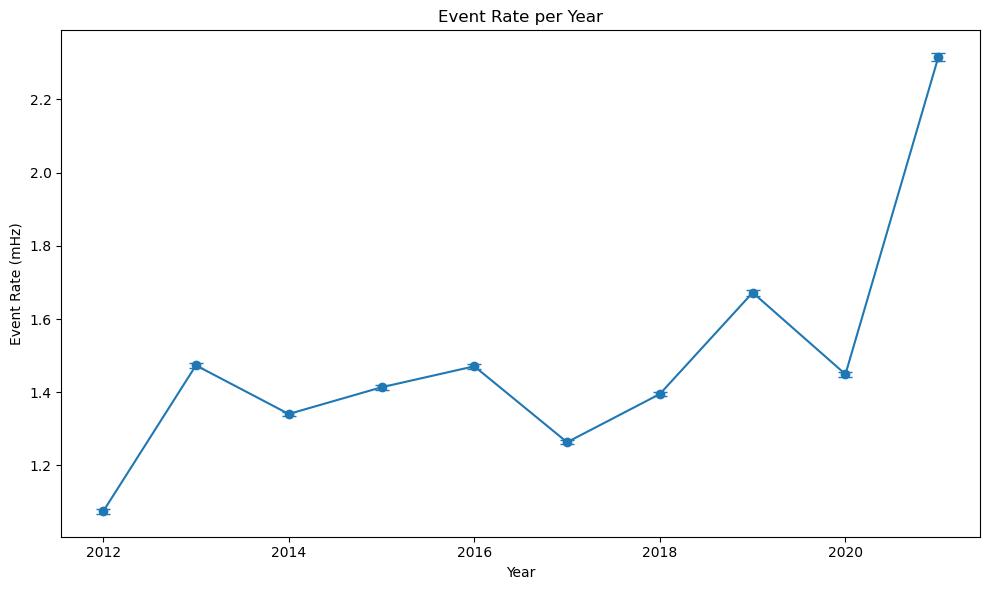

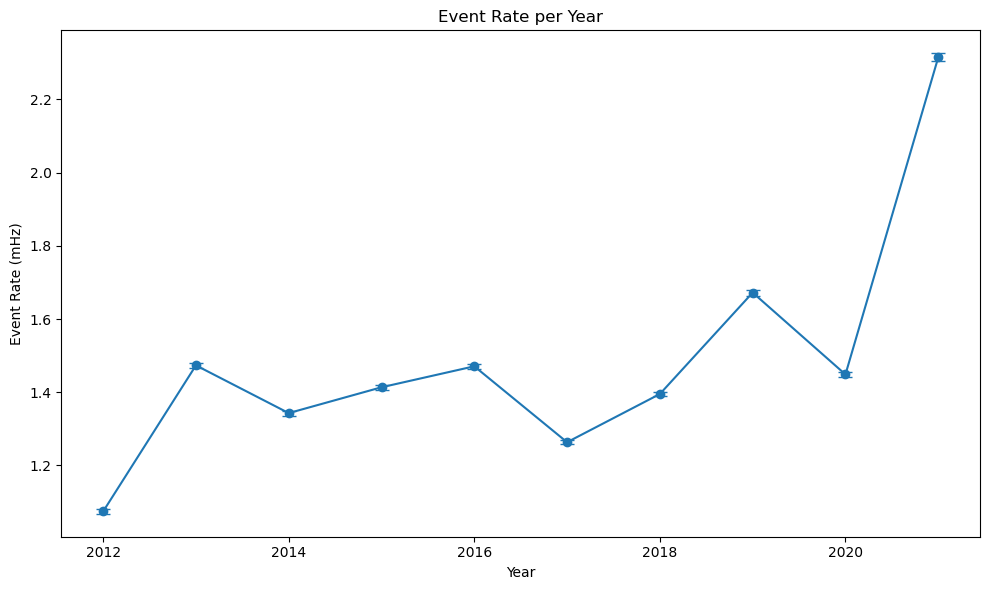

In [8]:
plot_event_rate(v204[0], np.array([0.88, 0.91, 0.99, 0.99, 0.96, 1.1, 1.0, 0.84, 0.98, 0.6]))
plot_event_rate(v200[0], np.array([0.88, 0.91, 0.99, 0.99, 0.96, 1.1, 1.0, 0.84, 0.98, 0.6]))

In [11]:
print(len(v204[1]))
print(len(v200[1]))



423599
423657


[]

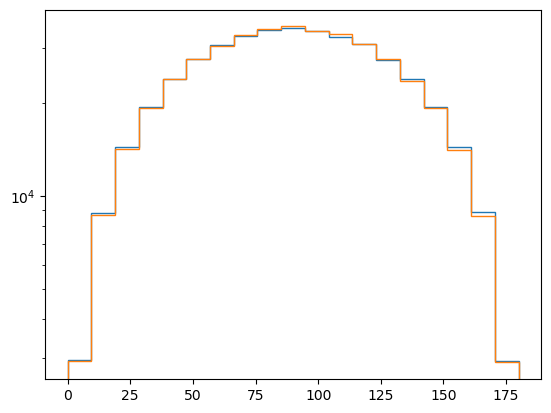

In [25]:
bin = np.linspace(0, 180, 20)
v1 = plt.hist(v204[2], histtype='step', bins=bin)
v2 = plt.hist(v200[2], histtype='step', bins=bin)
plt.semilogy()

In [26]:
v1

(array([ 2953.,  8775., 14343., 19283., 23841., 27666., 30753., 32716.,
        34309., 34769., 34008., 32672., 30804., 27436., 23800., 19364.,
        14321.,  8852.,  2934.]),
 array([  0.        ,   9.47368421,  18.94736842,  28.42105263,
         37.89473684,  47.36842105,  56.84210526,  66.31578947,
         75.78947368,  85.26315789,  94.73684211, 104.21052632,
        113.68421053, 123.15789474, 132.63157895, 142.10526316,
        151.57894737, 161.05263158, 170.52631579, 180.        ]),
 [<matplotlib.patches.Polygon at 0x7fe23a0a11b0>])

(array([  22.,  112.,  133.,   13.,   88.,  -80.,  236., -346., -262.,
        -434.,   52., -495.,  -50., -131.,  412.,  158.,  224.,  253.,
          37.]),
 array([  0.        ,   9.47368421,  18.94736842,  28.42105263,
         37.89473684,  47.36842105,  56.84210526,  66.31578947,
         75.78947368,  85.26315789,  94.73684211, 104.21052632,
        113.68421053, 123.15789474, 132.63157895, 142.10526316,
        151.57894737, 161.05263158, 170.52631579, 180.        ]),
 <BarContainer object of 19 artists>)

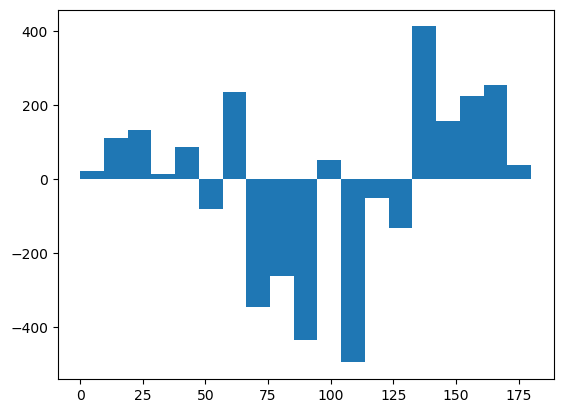

In [29]:
plt.hist(v1[1][0:-1] + np.diff(v1[1])/2., bins=v1[1],weights = v1[0]-v2[0])

In [6]:
a = ExtractMC(['121122', '141122', '161122'])

In [13]:
a.keys()

dict_keys(['nutype', 'E_true', 'E_reco', 'psi_true', 'psi_reco', 'PID', 'Dec_true', 'RA_true', 'Dec_reco', 'RA_reco', 'AtmWeight', 'w', 'oneweight'])

(array([0.16020093, 0.16230874, 0.16175267, 0.15799543, 0.15829226,
        0.16109891, 0.16023099, 0.15734168, 0.1566278 , 0.15571104]),
 array([5.85081095e-06, 6.28320034e-01, 1.25663422e+00, 1.88494840e+00,
        2.51326258e+00, 3.14157677e+00, 3.76989095e+00, 4.39820513e+00,
        5.02651932e+00, 5.65483350e+00, 6.28314768e+00]),
 [<matplotlib.patches.Polygon at 0x7fee66e7d810>])

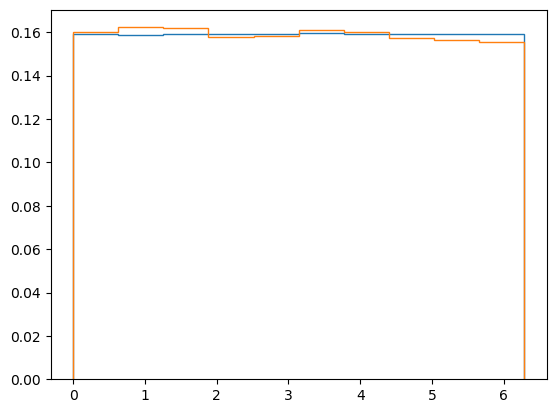

In [24]:
plt.hist(a['RA_reco'], histtype='step', density=True)
plt.hist(v204[3], histtype='step', density=True)

In [8]:
a['RA_reco']

array([0.84209107, 0.66966875, 5.19531882, ..., 2.46283831, 4.36090591,
       6.17403397])

In [18]:
max(v204[3])

6.283147682603287